In [4]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import seaborn as sns
from sklearn import preprocessing#, preprocessing
from matplotlib import pyplot as plt
from matplotlib import pylab as plb
from matplotlib import cm as cm
%matplotlib inline

In [5]:
import xgboost as xgb

In [6]:
train_df = pd.read_csv("train_clean.csv")
read_columns = ['timestamp', 'oil_urals', 'gdp_quart_growth', 'cpi', 'usdrub', \
                'salary_growth', 'unemployment', 'average_provision_of_build_contract_moscow', 'mortgage_rate', \
                 'deposits_rate','deposits_growth','rent_price_3room_eco',\
                 'rent_price_3room_bus']
macro_df = pd.read_csv("macro.csv",usecols=read_columns)

In [7]:
train_df.shape

(30471, 292)

In [8]:
train_df.columns

Index([u'id', u'timestamp', u'full_sq', u'life_sq', u'floor', u'max_floor',
       u'material', u'build_year', u'num_room', u'kitch_sq',
       ...
       u'cafe_count_5000_price_2500', u'cafe_count_5000_price_4000',
       u'cafe_count_5000_price_high', u'big_church_count_5000',
       u'church_count_5000', u'mosque_count_5000', u'leisure_count_5000',
       u'sport_count_5000', u'market_count_5000', u'price_doc'],
      dtype='object', length=292)

### Price trend

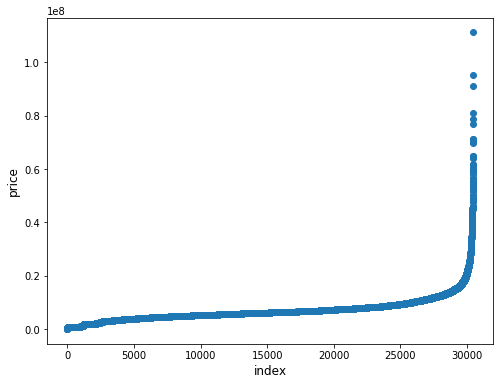

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

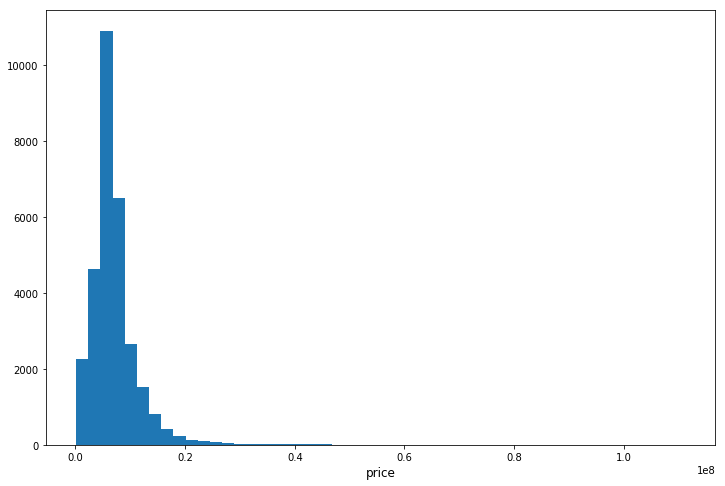

In [10]:
plt.figure(figsize=(12,8))
plt.hist(train_df.price_doc.values, bins=50)
plt.xlabel('price', fontsize=12)
plt.show()

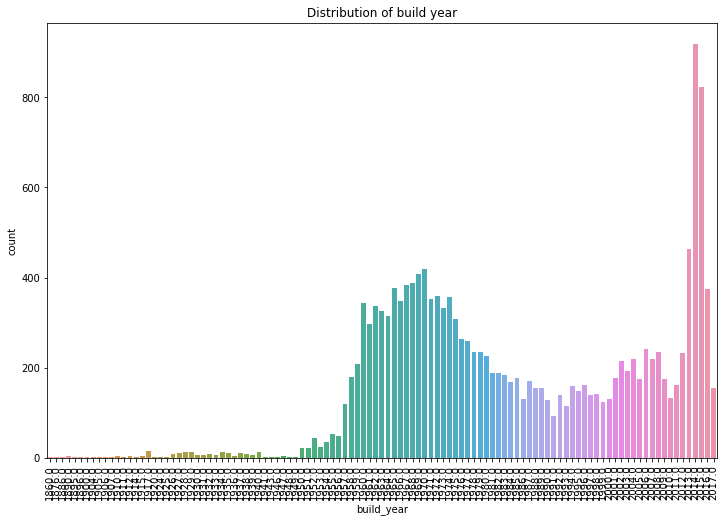

In [11]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90', )
ind = train_df[(train_df['build_year'] <= 1691) | (train_df['build_year'] >= 2018)].index
by_df = train_df.drop(ind).sort_values(by=['build_year'])
sns.countplot(x=by_df['build_year'])
ax.set(title='Distribution of build year')
## ax.set_xticks(ax.get_xticks()[::2])
plt.show()

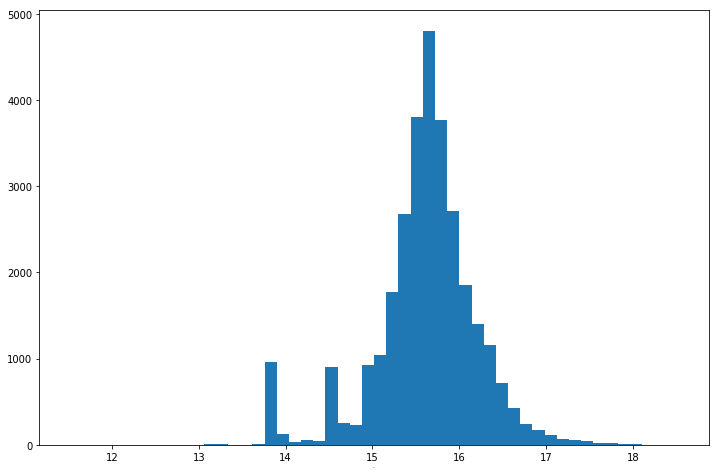

In [12]:
plt.figure(figsize=(12,8))
plt.hist(np.log(train_df.price_doc.values), bins=50)
plt.xlabel('price', fontsize=1)
plt.show()

Построим временной ряд медианной цены квартиры:

In [13]:
train_df['yearmonth'] = train_df['timestamp'].apply(lambda x: x[:4]+x[5:7])
import datetime
grouped_df = train_df.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()
grouped_df['datetime'] = grouped_df.yearmonth.apply(lambda x: datetime.datetime(int(x[:4]), int(x[4:6]), 1)) 
grouped_df[0:10]

,yearmonth,price_doc,datetime
0,201108,5850000.0,2011-08-01
1,201109,5200000.0,2011-09-01
2,201110,5500000.0,2011-10-01
3,201111,5600000.0,2011-11-01
4,201112,5450000.0,2011-12-01
5,201201,6100000.0,2012-01-01
6,201202,5700000.0,2012-02-01
7,201203,6175000.0,2012-03-01
8,201204,6200000.0,2012-04-01
9,201205,6100000.0,2012-05-01


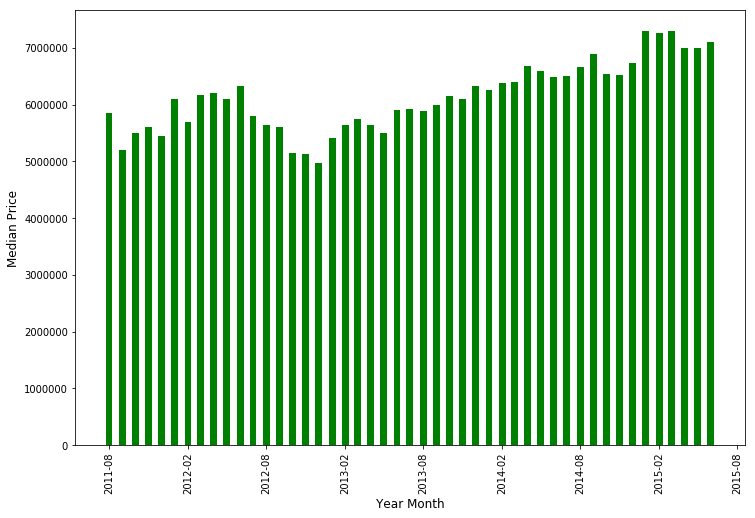

In [14]:
plt.figure(figsize=(12,8))
date_x = grouped_df.datetime.values
plt.bar(date_x, grouped_df.price_doc.values, width=16,color='green',align='center')
plt.xscale
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Year Month', fontsize=12)

plt.xticks(rotation='vertical')
plt.show()

Как мы видим, очень много данных не хватает. К счастью, мы можем построить xgboost и на имеющемся

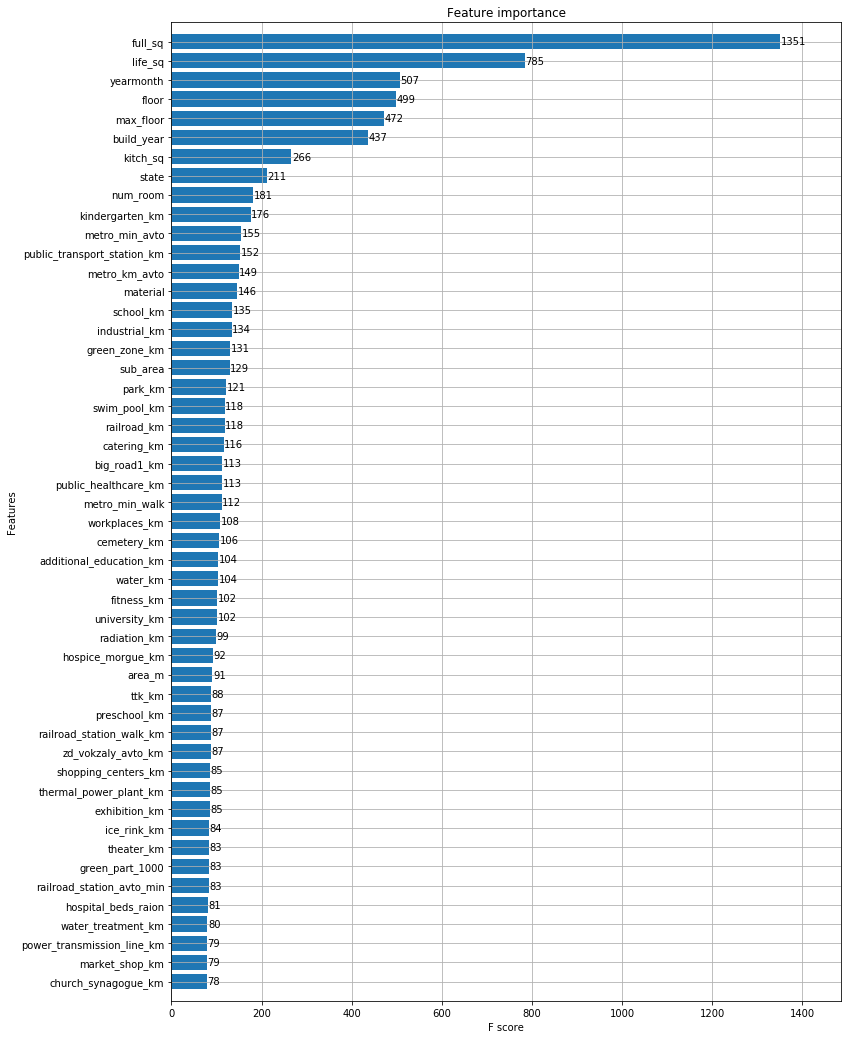

In [15]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values)) 
        train_df[f] = lbl.transform(list(train_df[f].values))
        
train_y = train_df.price_doc.values
train_X = train_df.drop(["id", "timestamp", "price_doc"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Корреляция

In [16]:
# def plot_corr(df,size=10):
#     '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

#     Input:
#         df: pandas DataFrame
#         size: vertical and horizontal size of the plot'''

#     corr = df.corr()
#     fig, ax = plt.subplots(figsize=(size, size))
#     ax.matshow(corr)
#     plt.xticks(range(len(corr.columns)), corr.columns);
#     plt.yticks(range(len(corr.columns)), corr.columns);
    
#     cax = ax.imshow(df.corr(), interpolation="nearest")
#     fig.colorbar(cax, ticks=[-0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9])
    
#     plt.show()

In [17]:
internal_chars = ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq', 'state', 'price_doc', ]
corrmat = train_df[internal_chars].corr()

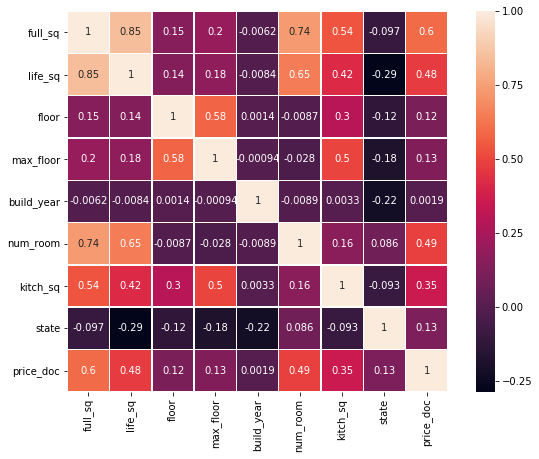

In [18]:
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)